# 라이브러리 임포트

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import struct
from glob import glob
from tqdm import tqdm
from pathlib import Path
import xml.etree.ElementTree as ET

from torchvision.transforms import functional as TF

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

target_size = (128, 128)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 함수 및 클래스 정의

In [2]:
def save_to_dat_file(file_name, data):
    data = np.array(data)
    data = np.mean(np.array(data), axis=2)
    height, width = data.shape

    data = data.astype(np.float32)

    with open(file_name, 'wb') as fout:
        fout.write(width.to_bytes(4, byteorder='little'))
        fout.write(height.to_bytes(4, byteorder='little'))

        for row in data:
            for pixel in row:
                fout.write(struct.pack('f', pixel.item()))   

def load_to_file(file_name):
    with open(file_name, 'rb') as fin:

        width = int.from_bytes(fin.read(4), byteorder='little')
        height = int.from_bytes(fin.read(4), byteorder='little')

        data_size = width * height
        
        pData = [struct.unpack('f', fin.read(4)) for _ in range(data_size)]
        pData = np.array(pData).reshape((height,width,1))

        pData = pData.astype(np.float32)

        return pData

In [3]:
def load_image_file(filename):
    image = Image.open(filename).convert('RGB') 
    image_array = np.array(image)    
    return image_array

In [4]:
def custom_loss(pred, target) :
    loss_mse = F.mse_loss(pred, target)
    loss_mae = F.l1_loss(pred, target)
    loss = 0.5 * loss_mae + 0.5 * loss_mse
    return loss

def custom_loss(pred, target):
    """
    pred: [B,1,H,W] 또는 [B,2,H,W] (채널0=depth, 채널1=logvar)
    target: [B,1,H,W]
    - target 내 NaN/Inf 는 자동 무시합니다(있다면).
    - 불확실성 헤드가 있을 경우(2채널) Gaussian NLL + 약한 엣지 정렬.
    - 없을 경우(1채널) L1 + 엣지 정렬.
    """
    assert pred.dim()==4 and target.dim()==4, "pred/target must be [B,C,H,W]"
    B = pred.size(0)

    # 유효 픽셀 마스크: target이 finite인 곳만 사용
    valid = torch.isfinite(target).float()
    target = torch.nan_to_num(target, nan=0.0, posinf=0.0, neginf=0.0)

    if pred.size(1) == 2:
        mu     = pred[:, 0:1]
        logvar = pred[:, 1:2].clamp(-10.0, 10.0)  # 수렴 안정화
        diff2  = (mu - target) ** 2
        nll    = (diff2 * torch.exp(-logvar) + logvar) * valid

        # 간단한 gradient 정렬(경계 보존)
        def grad(img):
            dx = img[:,:,:,1:] - img[:,:,:,:-1]
            dy = img[:,:,1:,:] - img[:,:,:-1,:]
            dx = F.pad(dx, (0,1,0,0))
            dy = F.pad(dy, (0,0,0,1))
            return dx, dy
        gpmx, gpmy = grad(mu)
        gtmx, gtmy = grad(target)
        gdiff = (gpmx-gtmx).abs() + (gpmy-gtmy).abs()
        gdiff = gdiff * valid

        denom = valid.sum().clamp_min(1.0)
        return nll.sum()/denom + 0.1 * gdiff.sum()/denom

    else:
        mu    = pred[:, 0:1]
        l1    = (mu - target).abs() * valid

        def grad(img):
            dx = img[:,:,:,1:] - img[:,:,:,:-1]
            dy = img[:,:,1:,:] - img[:,:,:-1,:]
            dx = F.pad(dx, (0,1,0,0))
            dy = F.pad(dy, (0,0,0,1))
            return dx, dy
        gpmx, gpmy = grad(mu)
        gtmx, gtmy = grad(target)
        gdiff = (gpmx-gtmx).abs() + (gpmy-gtmy).abs()
        gdiff = gdiff * valid

        denom = valid.sum().clamp_min(1.0)
        return l1.sum()/denom + 0.5 * gdiff.sum()/denom

In [5]:
def create_roi_mask(depth_map, bounding_boxes):
    H, W = depth_map.shape[:2]
    mask = np.ones((H, W), dtype=np.uint8)

    for box in bounding_boxes:
        if len(box) < 5:
            continue
        xmin = max(0, int(box[0]))
        ymin = max(0, int(box[1]))
        xmax = min(W - 1, int(box[2]))
        ymax = min(H - 1, int(box[3]))

        mask[ymin:ymax + 1, xmin:xmax + 1] = 0

    return mask[..., np.newaxis]

def read_xml_file(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bounding_boxes = []

    for obj in root.findall('.//object'):
        name = int(obj.find('name').text)
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))

        bounding_boxes.append([xmin, ymin, xmax, ymax, name])

    return bounding_boxes

In [6]:
# 충돌 방지용 상수명
E_IDX, W_IDX, S_IDX, N_IDX = 0, 1, 2, 3  # t 채널 순서: [E,W,S,N, Y, R, G, B, M] 가정

def _reorder_first4(t: torch.Tensor, new0123):
    """
    t: [C,H,W], C>=4
    new0123: 새 [E,W,S,N]가 가리킬 '이전' 인덱스 리스트(예: [S_IDX, N_IDX, W_IDX, E_IDX])
    안전하게 dim=0 재배열(index_select) 사용.
    """
    C = int(t.shape[0])
    first4 = torch.tensor([int(new0123[0]), int(new0123[1]),
                           int(new0123[2]), int(new0123[3])],
                           dtype=torch.long, device=t.device)
    rest   = torch.arange(4, C, dtype=torch.long, device=t.device)
    idx    = torch.cat([first4, rest], dim=0)
    return torch.index_select(t, dim=0, index=idx)

def oriented_random_transform(t: torch.Tensor, enable_flip=True, enable_rot=True):
    """
    t: [C,H,W], 채널 0..3 = [E,W,S,N]
    플립/회전에 따라 EWSN 채널 재배열을 함께 수행.
    """
    # 좌우 플립: E<->W
    if enable_flip and random.random() < 0.5:
        t = torch.flip(t, dims=[2])                               # W-dim
        t = _reorder_first4(t, [W_IDX, E_IDX, S_IDX, N_IDX])

    # 상하 플립: S<->N
    if enable_flip and random.random() < 0.5:
        t = torch.flip(t, dims=[1])                               # H-dim
        t = _reorder_first4(t, [E_IDX, W_IDX, N_IDX, S_IDX])

    # 90° 회전 k회(반시계)
    if enable_rot:
        k = random.choice([0,1,2,3])
        if k:
            t = torch.rot90(t, k=k, dims=(1,2))
            if k == 1:        # 90° CCW
                t = _reorder_first4(t, [S_IDX, N_IDX, W_IDX, E_IDX])
            elif k == 2:      # 180°
                t = _reorder_first4(t, [W_IDX, E_IDX, N_IDX, S_IDX])
            else:             # 270° CCW (== 90° CW)
                t = _reorder_first4(t, [N_IDX, S_IDX, E_IDX, W_IDX])
    return t

# ---------------- 드롭인 Dataset ----------------
class PreloadedDataset(Dataset):
    """
    dat_list 항목: numpy array (H, W, 9)
      채널 순서: [E, W, S, N, Y(depth), R, G, B, M(mask)]
    반환: x_dirs(4), y(1), i_rgb(3), m_mask(1)
    - train 모드 + use_aug=True 일 때만 채널-의식 증강 수행
    """
    def __init__(self, dat_list, target_size=None, mode='train', use_aug=True, device='cuda'):
        self.data = dat_list
        self.target_size = target_size  # (w,h) 사용할 경우 외부에서 리사이즈 처리 권장
        self.mode = mode
        self.use_aug = use_aug
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        arr = self.data[idx]                               # (H, W, 9)
        t = torch.from_numpy(arr).permute(2,0,1).float()   # (9, H, W)

        # 채널-의식 증강 (train일 때만)
        if self.mode == 'train' and self.use_aug:
            t = oriented_random_transform(t, enable_flip=True, enable_rot=True)

        # 분리: [E,W,S,N] | depth | RGB | mask
        x_dirs = t[0:4]    # (4,H,W)
        y      = t[4:5]    # (1,H,W)
        i_rgb  = t[5:8]    # (3,H,W)
        m_mask = t[8:9]    # (1,H,W)

        return (x_dirs.to(self.device),
                y.to(self.device),
                i_rgb.to(self.device),
                m_mask.to(self.device))

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# 모델 선택

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [GN] => ReLU) * 2 + SEBlock"""
    def __init__(self, in_channels, out_channels, mid_channels=None, num_groups=16):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, num_groups=16):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, num_groups=num_groups)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True, num_groups=16):
        super().__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='nearest')
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, num_groups)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, num_groups=num_groups)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DualInputUNetWithDepthScale(nn.Module):
    def __init__(self, bilinear=True, num_groups=16):
        super().__init__()
        factor = 2 if bilinear else 1

        # RGB 경로
        self.rgb_inc   = DoubleConv(3, 32, num_groups=num_groups)
        # extra 경로: 4ch → 1ch
        self.extra_inc = nn.Conv2d(4, 1, kernel_size=1)

        # UNet 본체 (RGB feature 32ch → down/upsampling)
        self.down1 = Down(32,  64,  num_groups=num_groups)
        self.down2 = Down(64, 128,  num_groups=num_groups)
        self.down3 = Down(128,256,  num_groups=num_groups)
        self.down4 = Down(256,512//factor, num_groups=num_groups)

        self.up1 = Up(512,   256//factor, bilinear, num_groups)
        self.up2 = Up(256,   128//factor, bilinear, num_groups)
        self.up3 = Up(128,    64//factor, bilinear, num_groups)
        self.up4 = Up(64,     32,         bilinear, num_groups)

        self.outc = OutConv(32, 1)  # normalized depth in [0..1]

    def forward(self, rgb, extra):
        # 1) RGB 경로로부터 normalized depth map (0..1)
        x = self.rgb_inc(rgb)        # (B,32,H,W)
        x1 = self.down1(x)           # (B,64,H/2,W/2)
        x2 = self.down2(x1)          # ...
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        x5 = self.up1(x4, x3)
        x6 = self.up2(x5, x2)
        x7 = self.up3(x6, x1)
        x8 = self.up4(x7, x)

        depth_norm = torch.sigmoid(self.outc(x8))  # (B,1,H,W) in [0,1]

        depth_value = self.extra_inc(extra)      # (B,1,H,W)
        depth_value = F.adaptive_avg_pool2d(depth_value, 1)

        depth_value = F.relu(depth_value)

        # 3) normalized output 에 depth_value 곱해 실제 scale 복원
        depth_out = depth_norm * depth_value      # (B,1,H,W)

        return depth_out

# 데이터 로딩

In [9]:
# Train에는 노이즈없이 깨끗한 데이터 + 라벨링 작업이 완료된 데이터
dat_dir   = glob('../데이터/3DImage/train/*/*/*3D_MergeDepth.dat')
east_dir  = glob('../데이터/3DImage/train/*/*/3D_Depth_E.dat')
west_dir  = glob('../데이터/3DImage/train/*/*/3D_Depth_W.dat')
south_dir = glob('../데이터/3DImage/train/*/*/3D_Depth_S.dat')
north_dir = glob('../데이터/3DImage/train/*/*/3D_Depth_N.dat')

dat_dir = sorted(dat_dir)
east_dir = sorted(east_dir)
west_dir = sorted(west_dir)
south_dir = sorted(south_dir)
north_dir = sorted(north_dir)

train_set = []

for y, e, w, s, n in tqdm(zip(dat_dir, east_dir, west_dir, south_dir, north_dir), total=len(dat_dir)):
    Y = load_to_file(y)
    E = load_to_file(e)
    W = load_to_file(w)
    S = load_to_file(s)
    N = load_to_file(n)

    i = Path(y.replace('3D_MergeDepth.dat', '2D_Vert.bmp'))
    I = load_image_file(i)
    
    m = Path(y.replace('.dat', '.xml'))
    if m.exists() :
        bbx = read_xml_file(m)
        M = create_roi_mask(Y, bbx)
    else :
        M = np.ones_like(Y)
    
    data = np.concatenate((E, W, S, N, Y, I, M), axis=-1)
    train_set.append(data)

# Test에는 라벨링 작업 진행중. 라벨 있는 샘플 -> 학습 및 검증에 사용, 라벨 없는 샘플 -> Test용
dat_dir = glob('../데이터/3DImage/test/*/*/*3D_MergeDepth.dat')
east_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_E.dat')
west_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_W.dat')
south_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_S.dat')
north_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_N.dat')

dat_dir = sorted(dat_dir)
east_dir = sorted(east_dir)
west_dir = sorted(west_dir)
south_dir = sorted(south_dir)
north_dir = sorted(north_dir)

for y, e, w, s, n in tqdm(zip(dat_dir, east_dir, west_dir, south_dir, north_dir), total=len(dat_dir)):
    Y = load_to_file(y)
    E = load_to_file(e)
    W = load_to_file(w)
    S = load_to_file(s)
    N = load_to_file(n)

    i = Path(y.replace('3D_MergeDepth.dat', '2D_Vert.bmp'))
    I = load_image_file(i)
    
    m = Path(y.replace('.dat', '.xml'))
    if m.exists() :
        bbx = read_xml_file(m)
        M = create_roi_mask(Y, bbx)
        data = np.concatenate((E, W, S, N, Y, I, M), axis=-1)
        train_set.append(data)
    else :
        pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2620/2620 [02:09<00:00, 20.25it/s]


In [10]:
test_set = []

dat_dir = glob('../데이터/3DImage/test/*/*/*3D_MergeDepth.dat')
east_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_E.dat')
west_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_W.dat')
south_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_S.dat')
north_dir = glob('../데이터/3DImage/test/*/*/3D_Depth_N.dat')

dat_dir = sorted(dat_dir)
east_dir = sorted(east_dir)
west_dir = sorted(west_dir)
south_dir = sorted(south_dir)
north_dir = sorted(north_dir)

for y, e, w, s, n in tqdm(zip(dat_dir, east_dir, west_dir, south_dir, north_dir), total=len(dat_dir)):
    Y = load_to_file(y)
    E = load_to_file(e)
    W = load_to_file(w)
    S = load_to_file(s)
    N = load_to_file(n)

    i = Path(y.replace('3D_MergeDepth.dat', '2D_Vert.bmp'))
    I = load_image_file(i)
    
    m = Path(y.replace('.dat', '.xml'))
    if not m.exists() :
        M = np.ones_like(Y)
        data = np.concatenate((E, W, S, N, Y, I, M), axis=-1)
        test_set.append(data)
    else :
        pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2620/2620 [01:48<00:00, 24.22it/s]


In [11]:
total_dataset = train_set

val_ratio = 0.15
n_total = len(total_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_set_, valid_set_ = random_split(total_dataset, [n_train, n_val])

# 학습 준비

In [12]:
model = DualInputUNetWithDepthScale(bilinear=True).to(device)
initialize_weights(model)

In [13]:
batch_size = 1

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=20, verbose=True)

E:\anaconda3_env\envs\TJKim\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
train_dataset = PreloadedDataset(train_set_, mode='train', use_aug=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = PreloadedDataset(valid_set_, mode='valid', use_aug=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [15]:
test_dataset = PreloadedDataset(test_set, mode='valid', use_aug=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 학습 시작!

In [16]:
def resize_with_padding(tensor, target_size=(128, 128), mode='bilinear'):
    B, C, H, W = tensor.shape
    target_h, target_w = target_size

    # 원본 크기 저장
    original_size = (H, W)

    # 종횡비 유지한 리사이즈 크기 계산
    scale = min(target_w / W, target_h / H)
    new_h, new_w = int(H * scale), int(W * scale)

    resized = F.interpolate(
        tensor, size=(new_h, new_w), mode=mode,
        align_corners=False if mode != 'nearest' else None
    )

    # 패딩 계산
    pad_h = target_h - new_h
    pad_w = target_w - new_w

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padded = F.pad(resized, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
    return padded, original_size

# 전체 텐서 리스트 다운샘플 + 크기 정보 저장
def downsample_tensor_batch(tensor_list):
    x, original_sizes = resize_with_padding(tensor_list[0], mode='bilinear')
    y, _ = resize_with_padding(tensor_list[1], mode='bilinear')
    i, _ = resize_with_padding(tensor_list[2] / 255., mode='bilinear')
    m, _ = resize_with_padding(tensor_list[3], mode='nearest')

    return x, y, i, m, original_sizes

def restore_to_original(tensor, original_size, mode='nearest'):
    return F.interpolate(
        tensor, size=original_size,
        mode=mode,
        align_corners=False if mode != 'nearest' else None
    )

In [17]:
# best_model_path =  r'E:\project\3d_noise\inpainting\restart\Moire-Depth\best_model.pth'
# state_dict = torch.load(best_model_path, map_location='cpu', weights_only=True)
# model.load_state_dict(state_dict)
# model = model.to('cuda')

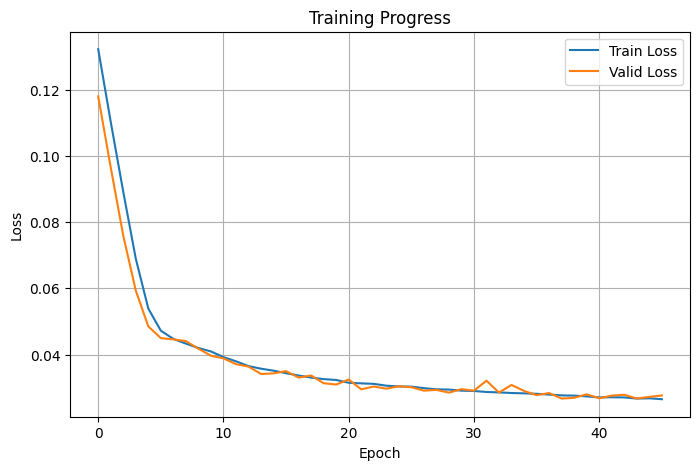

KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

history = []
model.train()
best_model = model
best_loss = 10000

train_loss_history = []
valid_loss_history = []

num_epochs = 200000
patience = 50
best_loss = float('inf')
counter = 0

confidence_list = []
interval_list = []

for epoch in range(num_epochs):
    ###### Train ######
    model.train()
    train_loss = 0.0

    for x, y, image, mask in train_dataloader:
        x, y, image, mask = x.to(device), y.to(device), image.to(device), mask.to(device)
        
        x, y, image, mask, _ = downsample_tensor_batch([x, y, image, mask])

        optimizer.zero_grad()
        output = model(image, x)

        masked_target = y * mask
        masked_output = output * mask
        
        max_tgt  = masked_target.view(masked_target.shape[0], -1).amax(dim=1).view(-1,1,1,1).clamp_min(1e-6)

        loss = custom_loss(masked_output / max_tgt, masked_target / max_tgt)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    ###### Valid ######
    model.eval()
    valid_loss = 0.0
    merged = None  # 저장할 데이터 준비

    with torch.no_grad():
        for batch_idx, (x_val, y_val, img_val, mask_val) in enumerate(valid_dataloader):
            x_val, y_val, img_val, mask_val = x_val.to(device), y_val.to(device), img_val.to(device), mask_val.to(device)

            x_val, y_val, img_val, mask_val, coord = downsample_tensor_batch([x_val, y_val, img_val, mask_val])
            
            output_val = model(img_val, x_val)

            masked_target_val = y_val * mask_val
            masked_output_val = output_val * mask_val

            max_tgt_val  = masked_target_val.view(masked_target_val.shape[0], -1).amax(dim=1).view(-1,1,1,1).clamp_min(1e-6)
            loss_val = custom_loss(masked_target_val / max_tgt_val, masked_output_val / max_tgt_val)
            
            valid_loss += loss_val.item()

            if batch_idx == 0:
                gt = y_val[0,0].cpu().numpy()
                pred = output_val[0,0].cpu().numpy()
                mask_np = mask_val[0,0].cpu().numpy().astype(bool)

                rows = np.any(mask_np, axis=1)
                cols = np.any(mask_np, axis=0)
                gt_crop   = gt[rows][:, cols][..., None]
                pred_crop = pred[rows][:, cols][..., None]
                merged = np.concatenate([gt_crop, pred_crop], axis=1)

    valid_loss_epoch = valid_loss / len(valid_dataloader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss_epoch)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss_epoch:.4f} | Counter: {counter}")

    # Early Stopping
    if valid_loss_epoch < best_loss:
        best_loss = valid_loss_epoch
        counter = 0
        torch.save(model.state_dict(), '../모델/best_model.pth')
        if merged is not None:
            save_to_dat_file(f'../모델/output_epoch{epoch+1}.dat', merged)
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_loss:.6f}")
            break

    # 실시간 그래프 업데이트
    clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(valid_loss_history, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
## 정규화 기준, 메디안 3, another_shape 제외, UNet
Early stopping at epoch 767. Best val loss: 840.143508

## 정규화 기준, 메디안 3, train, another 만 학습, UNet
Early stopping at epoch 183. Best val loss: 1401.180986

## 정규화 없음, train 학습 UNet(0.5)
Early stopping at epoch 199. Valid Loss: 348.4743

## 정규화 없음, train, another 학습 UNet(0.5)
Early stopping at epoch 594. Valid Loss: 154.7076

## 정규화 없음, train, another 학습 UNet(0.5), 배치 1
Early stopping at epoch 594. Valid Loss: 154.7076

## 정규화 없음, train another 학습 UNet(0.2)
Early stopping at epoch 359. Best val loss: 576.785149

## 정규화 없음, train another 학습 UNet(0.5)
Early stopping at epoch 504. Best val loss: 469.384471

## 정규화 없음, train another 학습 UNet(1.0)
Early stopping at epoch 217. Best val loss: 1008.170885

## zscore 5 -->zcore는 평평한 영역이 뾰족뾰족하게 만들어짐
Early stopping at epoch 588. Best val loss: 766.671943

## zscore 3
Early stopping at epoch 282. Best val loss: 680.499732

## zscore 2
Early stopping at epoch 255. Best val loss: 843.582516

## zscore 1
Early stopping at epoch 723. Best val loss: 2313.067925

# 검증

In [19]:
best_model = DualInputUNetWithDepthScale(bilinear=True)
best_model_path =  r'../모델/best_model.pth'
state_dict = torch.load(best_model_path, map_location='cpu', weights_only=True)
best_model.load_state_dict(state_dict)
best_model = best_model.to('cuda')
best_model.eval()
print()

In [22]:
count = 0
valid_loss_sum = 0.0
num_batches = 0

with torch.no_grad():
    for batch_idx, (x_val, y_val, img_val, mask_val) in enumerate(test_dataloader):
        x_val   = x_val.to(device)
        y_val   = y_val.to(device)
        img_val = img_val.to(device)
        mask_val= mask_val.to(device)

        x_val, y_val, img_val, mask_val, coord = downsample_tensor_batch([x_val, y_val, img_val, mask_val])

        # 모델 호출 (그대로)
        output_val = model(img_val, x_val)  # [B,1,H,W]

        # 손실 (정규화 동일)
        masked_target_val = y_val * mask_val
        masked_output_val = output_val * mask_val
        max_tgt_val = masked_target_val.flatten(1).amax(1).view(-1,1,1,1).clamp_min(1e-6)
        loss_val = custom_loss(masked_target_val / max_tgt_val,
                               masked_output_val / max_tgt_val)
        valid_loss_sum += loss_val.item()
        num_batches    += 1

        # ===== 저장: 배치 첫 샘플 1장, (h, 2w, 1) 보장 =====
        b = 0
        gt    = y_val[b,0].detach().cpu().numpy()          # (H,W)
        pred  = output_val[b,0].detach().cpu().numpy()     # (H,W)
        m_np  = mask_val[b,0].detach().cpu().numpy().astype(bool)

        rows = m_np.any(axis=1)
        cols = m_np.any(axis=0)
        if rows.any() and cols.any():
            gt_crop   = gt[np.ix_(rows, cols)]             # (h,w)
            pred_crop = pred[np.ix_(rows, cols)]           # (h,w)
        else:
            gt_crop, pred_crop = gt, pred                  # 마스크 비었으면 원본

        # (h,2w,1)로 저장: 채널축 추가 후 가로 concat
        merged = np.concatenate([
            gt_crop[..., None],         # (h,w,1)
            pred_crop[..., None]        # (h,w,1)
        ], axis=1).astype(np.float32)   # -> (h,2w,1)

        count += 1
        save_to_dat_file(f'../데이터/3DImage/output_test/{count:05d}.dat', merged)

# 평균 loss
valid_loss = valid_loss_sum / max(1, num_batches)
print(f"[TEST] valid_loss(avg): {valid_loss:.6f}, batches: {num_batches}")

[TEST] valid_loss(avg): 0.043763, batches: 1448


In [23]:
import os
from pathlib import Path
import numpy as np
import cv2  # pip install opencv-python

save_root = Path("../데이터/3DImage/output_test")
save_root.mkdir(parents=True, exist_ok=True)

def _to_hw1(a2d: np.ndarray) -> np.ndarray:
    return a2d[..., None] if a2d.ndim == 2 else a2d

def _parse_coord_one(c):
    """
    c: coord for one sample. Supports:
      - tuple/list of 4 ints
      - 1D tensor of len 4
    Returns (y0, x0, y1, x1).
    """
    if hasattr(c, "detach"):  # torch tensor
        c = c.detach().cpu().tolist()
    c = list(map(int, c))
    if len(c) != 4:
        return None
    y0, a, y1, b = c
    # try (y0,x0,y1,x1)
    x0, x1 = a, b
    if y1 > y0 and x1 > x0:
        return (y0, x0, y1, x1)
    # try (y0,y1,x0,x1)
    x0, x1 = y1, b
    y1 = a
    if y1 > y0 and x1 > x0:
        return (y0, x0, y1, x1)
    return None

count = 0
valid_loss_sum = 0.0
num_batches = 0

model.eval()
with torch.no_grad():
    for batch_idx, (x_val, y_val, img_val, mask_val) in enumerate(test_dataloader):
        # ----- 원본 텐서 보관 (crop용; downsample 전에 복사) -----
        x_full   = x_val.to(device)    # [B,4,H0,W0]
        y_full   = y_val.to(device)    # [B,1,H0,W0]
        img_full = img_val.to(device)  # [B,3,H0,W0]
        mask_full= mask_val.to(device) # [B,1,H0,W0]

        # ↓ 기존 파이프라인 유지
        x_val, y_val, img_val, mask_val, coord = downsample_tensor_batch(
            [x_val.to(device), y_val.to(device), img_val.to(device), mask_val.to(device)]
        )

        # 모델 호출 (그대로)
        output_val = model(img_val, x_val)  # [B,1,128,128]

        # 손실 (정규화 동일)
        masked_target_val = y_val * mask_val
        masked_output_val = output_val * mask_val
        max_tgt_val = masked_target_val.flatten(1).amax(1).view(-1,1,1,1).clamp_min(1e-6)
        loss_val = custom_loss(masked_target_val / max_tgt_val,
                               masked_output_val / max_tgt_val)
        valid_loss_sum += loss_val.item()
        num_batches    += 1

        # ===== 저장: 배치 내 모든 샘플 =====
        B = output_val.size(0)
        for b in range(B):
            count += 1
            prefix = save_root / f"sample_{count:05d}"

            # ---- coord 해석 → (y0,x0,y1,x1)
            if isinstance(coord, (list, tuple)) and len(coord) == B:
                c = coord[b]
            else:
                c = coord[b] if hasattr(coord, "shape") and coord.ndim >= 2 else coord
            parsed = _parse_coord_one(c) if c is not None else None

            H0, W0 = int(y_full.shape[-2]), int(y_full.shape[-1])
            if parsed is not None:
                y0, x0, y1, x1 = parsed
                y0 = max(0, min(y0, H0)); y1 = max(0, min(y1, H0))
                x0 = max(0, min(x0, W0)); x1 = max(0, min(x1, W0))
                if not (y1 > y0 and x1 > x0):
                    y0, x0, y1, x1 = 0, 0, H0, W0
            else:
                y0, x0, y1, x1 = 0, 0, H0, W0

            # ---- GT crop
            gt_crop = y_full[b,0, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)  # (hc,wc)

            # ---- Pred 복원 (letterbox 역연산 후 원본 crop 크기로 resize)
            pred_128 = output_val[b,0].detach().cpu().numpy().astype(np.float32)  # (128,128)
            target = pred_128.shape[0]
            hc, wc = gt_crop.shape

            scale = min(target / max(wc, 1e-6), target / max(hc, 1e-6))
            h_c = int(round(hc * scale))
            w_c = int(round(wc * scale))
            h_c = max(1, min(h_c, target))
            w_c = max(1, min(w_c, target))

            pad_y = (target - h_c) // 2
            pad_x = (target - w_c) // 2

            pred_content = pred_128[pad_y:pad_y+h_c, pad_x:pad_x+w_c]
            pred_restored = cv2.resize(pred_content, (wc, hc), interpolation=cv2.INTER_CUBIC)

            # ---- Vert crop 저장
            vert_crop = img_full[b, :, y0:y1, x0:x1].detach().cpu().numpy()  # [3,h,w]
            vert_crop = np.transpose(vert_crop, (1,2,0))                     # [h,w,3]
            vmax = vert_crop.max()
            if vmax <= 1.0:
                vert_u8 = np.clip(vert_crop * 255.0, 0, 255).astype(np.uint8)
            else:
                vert_u8 = np.clip(vert_crop, 0, 255).astype(np.uint8)
            cv2.imwrite(str(prefix.with_name(prefix.stem + "_vert.png")), vert_u8[:, :, ::-1])

            # ---- E/W/S/N crop 2×2 저장
            E_crop = x_full[b,0, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            W_crop = x_full[b,1, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            S_crop = x_full[b,2, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            N_crop = x_full[b,3, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)

            top_row    = np.concatenate([E_crop, W_crop], axis=1)
            bottom_row = np.concatenate([S_crop, N_crop], axis=1)
            ewsn_2x2   = np.concatenate([top_row, bottom_row], axis=0)
            save_to_dat_file(str(prefix.with_name(prefix.stem + "_EWSN_2x2.dat")), _to_hw1(ewsn_2x2))

            # ---- GT | Pred crop 좌우 합치기
            gt_pred_lr = np.concatenate([gt_crop, pred_restored], axis=1)   # (hc, 2*wc)
            save_to_dat_file(str(prefix.with_name(prefix.stem + "_GT_PRED_crop.dat")),
                             _to_hw1(gt_pred_lr))

# 평균 loss 출력
valid_loss = valid_loss_sum / max(1, num_batches)
print(f"[TEST SAVE] avg loss: {valid_loss:.6f}, saved samples: {count}")

[TEST SAVE] avg loss: 0.043763, saved samples: 1448


In [24]:
def save_to_dat_file(file_name, data):
    """
    data: (H,W,1) 또는 (H,W,3) 또는 (H,W)
      - (H,W,3)인 경우 axis=2 평균 (원래 코드와 동일 동작)
      - (H,W,1)은 채널 제거
      - NaN/Inf → 0, 음수 → 0
      - 0 ~ max(data) 범위로 클리핑한 뒤 float32 리틀엔디언으로 저장
    파일 포맷:
      [4바이트 width][4바이트 height][height*width개의 float32 little-endian]
    """
    arr = np.array(data)

    # 채널 차원 처리 (원 코드와 호환)
    if arr.ndim == 3:
        if arr.shape[2] == 1:
            arr = arr[:, :, 0]
        else:
            # (H,W,3) → 평균
            arr = np.mean(arr, axis=2)
    elif arr.ndim > 3:
        # 혹시 이상 차원이면 squeeze 후 다시 처리
        arr = np.squeeze(arr)
        if arr.ndim == 3:
            if arr.shape[2] == 1:
                arr = arr[:, :, 0]
            else:
                arr = np.mean(arr, axis=2)

    # 안전화: NaN/Inf 제거, 음수 제거
    arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32, copy=False)
    np.maximum(arr, 0.0, out=arr)  # 음수 → 0

    # vmax 계산 및 0~vmax 클리핑
    vmax = float(arr.max()) if arr.size else 0.0
    if not np.isfinite(vmax) or vmax <= 0.0:
        vmax = 1e-6
    np.clip(arr, 0.0, vmax, out=arr)

    height, width = arr.shape

    # little-endian float32로 직렬화하여 저장 (루프보다 빠름)
    with open(file_name, 'wb') as fout:
        fout.write(width.to_bytes(4, byteorder='little', signed=False))
        fout.write(height.to_bytes(4, byteorder='little', signed=False))
        fout.write(arr.astype('<f4', copy=False).tobytes(order='C'))

In [26]:
import numpy as np
import cv2

def make_vert_on_pred_u8(
    vert_crop: np.ndarray,
    pred_restored: np.ndarray,
    mask_crop: np.ndarray | None = None,
    alpha: float = 0.45,
    colormap: int = cv2.COLORMAP_JET,
) -> np.ndarray:
    """
    vert_crop : (H,W,3) RGB, float[0..1] 또는 [0..255]
    pred_restored : (H,W) float, 값 범위는 자유
    mask_crop : (H,W) float/bool, 1=유효/0=무시 (optional)
    alpha : heatmap 가중치 (0~1)
    colormap : OpenCV 컬러맵 (기본 JET)

    return : (H,W,3) RGB uint8 (imwrite 전에 BGR 변환 필요)
    """
    assert vert_crop.ndim == 3 and vert_crop.shape[2] == 3, "vert_crop must be (H,W,3)"
    assert pred_restored.ndim == 2, "pred_restored must be (H,W)"
    H, W, _ = vert_crop.shape
    assert pred_restored.shape == (H, W), "shape mismatch between vert_crop and pred_restored"

    # --- 1) 입력 클린업 ---
    vert = vert_crop.astype(np.float32)
    vmax = float(np.nanmax(vert))
    if vmax <= 1.0 + 1e-6:
        vert = np.clip(vert * 255.0, 0, 255)
    else:
        vert = np.clip(vert, 0, 255)

    pred = pred_restored.astype(np.float32)
    if mask_crop is not None:
        m = (mask_crop > 0.5).astype(np.float32)
        # 마스크 밖은 NaN으로 두고 min-max 구해 안정화
        valid = np.isfinite(pred) & (m > 0)
        if np.any(valid):
            p = pred.copy()
            p[~valid] = np.nan
            p_min = np.nanmin(p)
            p_max = np.nanmax(p)
        else:
            # 유효값이 없으면 전부 0으로
            p_min, p_max = 0.0, 1.0
    else:
        m = None
        valid = np.isfinite(pred)
        if np.any(valid):
            p_min = float(np.nanmin(pred))
            p_max = float(np.nanmax(pred))
        else:
            p_min, p_max = 0.0, 1.0

    # --- 2) pred 정규화 [0,1] → [0,255] ---
    if p_max - p_min < 1e-8:
        pred_norm = np.zeros_like(pred, dtype=np.float32)
    else:
        pred_norm = (pred - p_min) / (p_max - p_min)
        pred_norm = np.clip(pred_norm, 0.0, 1.0)

    pred_u8 = (pred_norm * 255.0).astype(np.uint8)

    # --- 3) 컬러맵 적용 (BGR) 후 RGB로 변환 ---
    heat_bgr = cv2.applyColorMap(pred_u8, colormap)          # (H,W,3) BGR uint8
    heat = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)

    # --- 4) 알파 블렌딩 (마스크가 있으면 유효 영역에서만) ---
    alpha = float(np.clip(alpha, 0.0, 1.0))
    if m is None:
        out = (1.0 - alpha) * vert + alpha * heat
    else:
        m3 = m[:, :, None]  # (H,W,1)
        out = vert.copy()
        out = (1.0 - alpha * m3) * out + (alpha * m3) * heat

    out = np.clip(out, 0, 255).astype(np.uint8)  # RGB uint8
    return out

In [27]:
import os
from pathlib import Path
import numpy as np
import cv2  # pip install opencv-python
import torch

# ==== 사용자 설정 ====
save_root = Path("../데이터/3DImage/output_test")
save_root.mkdir(parents=True, exist_ok=True)
CENTER_PAD = True   # keep_aspect letterbox가 '센터 패딩'이면 True, '좌상단 패딩'이면 False

# ==== 헬퍼 ====
def _to_hw1(a2d: np.ndarray) -> np.ndarray:
    """(H,W)->(H,W,1) 보장"""
    return a2d[..., None] if a2d.ndim == 2 else a2d

def _parse_coord_one(c):
    """
    c: one sample coord; supports list/tuple/1D tensor of 4 numbers.
    Tries (y0,x0,y1,x1) then (y0,y1,x0,x1). Returns (y0,x0,y1,x1) or None.
    """
    if hasattr(c, "detach"):
        c = c.detach().cpu().tolist()
    c = list(map(int, c))
    if len(c) != 4: 
        return None
    y0, a, y1, b = c
    # try (y0,x0,y1,x1)
    x0, x1 = a, b
    if y1 > y0 and x1 > x0:
        return (y0, x0, y1, x1)
    # try (y0,y1,x0,x1)
    x0, x1 = y1, b
    y1 = a
    if y1 > y0 and x1 > x0:
        return (y0, x0, y1, x1)
    return None

def _restore_pred_to_crop(pred_128: np.ndarray, hc: int, wc: int, center_pad: bool = True) -> np.ndarray:
    """
    128x128 pred (letterbox된 네트워크 출력) → 원본 crop 크기(hc,wc)로 복원
    keep_aspect_ratio=True 가정. center_pad=False면 좌상단 패딩 가정.
    """
    target = pred_128.shape[0]  # 128
    # 원본 크기(hc,wc) → letterbox 유효크기(h_c,w_c)
    scale = min(target / max(wc, 1e-6), target / max(hc, 1e-6))
    h_c = int(round(hc * scale))
    w_c = int(round(wc * scale))
    h_c = max(1, min(h_c, target))
    w_c = max(1, min(w_c, target))

    if center_pad:
        pad_y = (target - h_c) // 2
        pad_x = (target - w_c) // 2
    else:
        pad_y, pad_x = 0, 0

    y0_p, y1_p = pad_y, pad_y + h_c
    x0_p, x1_p = pad_x, pad_x + w_c
    # clamp
    y0_p = max(0, min(y0_p, target)); y1_p = max(0, min(y1_p, target))
    x0_p = max(0, min(x0_p, target)); x1_p = max(0, min(x1_p, target))

    pred_content = pred_128[y0_p:y1_p, x0_p:x1_p]                # (h_c, w_c)
    pred_restored = cv2.resize(pred_content, (wc, hc), interpolation=cv2.INTER_CUBIC)  # (hc,wc)
    return pred_restored.astype(np.float32)

# ==== 저장 루프 (모델/파이프라인 그대로) ====
count = 0
valid_loss_sum = 0.0
num_batches = 0

model.eval()
with torch.no_grad():
    for batch_idx, (x_val, y_val, img_val, mask_val) in enumerate(test_dataloader):
        # 원본 텐서(크롭용) 보관
        x_full   = x_val.to(device)    # [B,4,H0,W0]
        y_full   = y_val.to(device)    # [B,1,H0,W0]
        img_full = img_val.to(device)  # [B,3,H0,W0]
        mask_full= mask_val.to(device) # [B,1,H0,W0]

        # 기존 파이프라인 유지 (downsample + coord)
        x_val, y_val, img_val, mask_val, coord = downsample_tensor_batch(
            [x_val.to(device), y_val.to(device), img_val.to(device), mask_val.to(device)]
        )

        # forward (그대로)
        output_val = model(img_val, x_val)  # [B,1,128,128] 가정

        # loss (그대로)
        masked_target_val = y_val * mask_val
        masked_output_val = output_val * mask_val
        max_tgt_val = masked_target_val.flatten(1).amax(1).view(-1,1,1,1).clamp_min(1e-6)
        loss_val = custom_loss(masked_target_val / max_tgt_val,
                               masked_output_val / max_tgt_val)
        valid_loss_sum += loss_val.item()
        num_batches    += 1

        # === 저장: 배치 내 모든 샘플 ===
        B = output_val.size(0)
        for b in range(B):
            count += 1
            prefix = save_root / f"sample_{count:05d}"

            # coord → (y0,x0,y1,x1)
            if isinstance(coord, (list, tuple)) and len(coord) == B:
                c = coord[b]
            else:
                c = coord[b] if hasattr(coord, "shape") and coord.ndim >= 2 else coord
            parsed = _parse_coord_one(c) if c is not None else None

            H0, W0 = int(y_full.shape[-2]), int(y_full.shape[-1])
            if parsed is not None:
                y0, x0, y1, x1 = parsed
                y0 = max(0, min(y0, H0)); y1 = max(0, min(y1, H0))
                x0 = max(0, min(x0, W0)); x1 = max(0, min(x1, W0))
                if not (y1 > y0 and x1 > x0):
                    y0, x0, y1, x1 = 0, 0, H0, W0
            else:
                y0, x0, y1, x1 = 0, 0, H0, W0

            # 원본 crop 추출
            gt_crop   = y_full[b,0, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)  # (hc,wc)
            E_crop    = x_full[b,0, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            W_crop    = x_full[b,1, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            S_crop    = x_full[b,2, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            N_crop    = x_full[b,3, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)
            vert_crop = img_full[b, :, y0:y1, x0:x1].detach().cpu().numpy()                  # [3,hc,wc]
            vert_crop = np.transpose(vert_crop, (1,2,0))                                     # (hc,wc,3)
            mask_crop = mask_full[b,0, y0:y1, x0:x1].detach().cpu().numpy().astype(np.float32)

            hc, wc = gt_crop.shape

            # pred 복원 (letterbox 역연산 → 원본 crop 크기로)
            pred_128 = output_val[b,0].detach().cpu().numpy().astype(np.float32)  # (128,128)
            pred_restored = _restore_pred_to_crop(pred_128, hc, wc, center_pad=CENTER_PAD)

            # --- (A) GT|Pred 좌우 결합 저장 (원본 crop 기준, 동일 크기) ---
            gt_pred_lr = np.concatenate([gt_crop, pred_restored], axis=1)   # (hc, 2*wc)
            save_to_dat_file(str(prefix.with_name(prefix.stem + "_GT_PRED_crop.dat")),
                             _to_hw1(gt_pred_lr).astype(np.float32))

            # --- (B) E/W/S/N 2×2 저장 (원본 crop) ---
            top_row    = np.concatenate([E_crop, W_crop], axis=1)           # (hc, 2*wc)
            bottom_row = np.concatenate([S_crop, N_crop], axis=1)           # (hc, 2*wc)
            ewsn_2x2   = np.concatenate([top_row, bottom_row], axis=0)      # (2*hc, 2*wc)
            save_to_dat_file(str(prefix.with_name(prefix.stem + "_EWSN_2x2_crop.dat")),
                             _to_hw1(ewsn_2x2).astype(np.float32))

            # --- (C) Vert crop PNG 저장 ---
            vmax = vert_crop.max()
            if vmax <= 1.0:
                vert_u8 = np.clip(vert_crop * 255.0, 0, 255).astype(np.uint8)
            else:
                vert_u8 = np.clip(vert_crop, 0, 255).astype(np.uint8)
            cv2.imwrite(str(prefix.with_name(prefix.stem + "_vert_crop.png")), vert_u8[:, :, ::-1])  # RGB->BGR

            # --- (D) Mask_map PNG 저장 (0/1 → 0/255) ---
            mask_u8 = ((1-mask_crop) * 255.0).clip(0,255).astype(np.uint8)
            cv2.imwrite(str(prefix.with_name(prefix.stem + "_mask.png")), mask_u8)

            vert_on_pred_u8 = make_vert_on_pred_u8(vert_crop, pred_restored, mask_crop, alpha=0.45)
            cv2.imwrite(str(prefix.with_name(prefix.stem + "_vert_on_pred.png")), vert_on_pred_u8[:, :, ::-1])  # RGB->BGR

# 평균 loss
valid_loss = valid_loss_sum / max(1, num_batches)
print(f"[TEST SAVE] avg loss: {valid_loss:.6f}, saved samples: {count}")

[TEST SAVE] avg loss: 0.043763, saved samples: 1448


In [ ]:
[TRAIN] avg loss: 0.013649
[VALID] avg loss: 0.023416
[TEST]  avg loss: 0.042289

# 추론 시간 확인

In [28]:
import time, math
import torch
import numpy as np

# =========================================
# 공용 유틸
# =========================================
def _now(): return time.perf_counter()

def _mean_std(xs):
    xs = list(xs)
    if not xs: return 0.0, 0.0
    m = sum(xs)/len(xs)
    v = sum((x-m)**2 for x in xs) / max(1, len(xs)-1)
    return m, math.sqrt(v)

def _ensure_cpu(obj):
    """배치 첫 단계: 무조건 CPU로 시작시킨다."""
    if torch.is_tensor(obj): return obj.detach().cpu()
    if isinstance(obj, (list, tuple)): return type(obj)(_ensure_cpu(x) for x in obj)
    if isinstance(obj, dict): return {k:_ensure_cpu(v) for k,v in obj.items()}
    return obj

def _to(obj, device, non_blocking=True):
    """컨테이너 안 텐서까지 지정 device로 이동."""
    if torch.is_tensor(obj): return obj.to(device, non_blocking=non_blocking)
    if isinstance(obj, (list, tuple)): return type(obj)(_to(x, device, non_blocking) for x in obj)
    if isinstance(obj, dict): return {k:_to(v, device, non_blocking) for k,v in obj.items()}
    return obj

def _sync_if_cuda(device):
    if isinstance(device, str):
        is_cuda = device.startswith("cuda")
    else:
        is_cuda = (device.type == "cuda")
    if is_cuda and torch.cuda.is_available(): torch.cuda.synchronize()

# =========================================
# 4 경로 벤치마크
# =========================================
def run_pipeline_1_cpu_prep_cpu_inf(model, dataloader, *, warmup=5, max_batches=50, print_every=10):
    """
    1) CPU 전처리 -> CPU 추론
    시작: CPU / 종료: CPU
    """
    device_model = torch.device("cpu")
    model_cpu = model.to(device_model).eval()

    t_prep=[]; t_h2d=[]; t_inf=[]; t_d2h=[]
    seen=0; warm=0

    with torch.inference_mode():
        for it, batch in enumerate(dataloader):
            # 항상 CPU에서 시작
            batch = _ensure_cpu(batch)
            # 배치 언팩
            if isinstance(batch, (list, tuple)) and len(batch) >= 4:
                x_cpu, y_cpu, img_cpu, mask_cpu = batch[:4]
            elif isinstance(batch, dict):
                x_cpu, y_cpu, img_cpu, mask_cpu = batch["x"], batch["y"], batch["img"], batch["mask"]
            else:
                raise RuntimeError("dataloader는 (x,y,img,mask)를 반환해야 합니다.")

            # (1) CPU 전처리
            t0 = _now()
            x_p, y_p, img_p, mask_p, *rest = downsample_tensor_batch([x_cpu, y_cpu, img_cpu, mask_cpu])
            t1 = _now(); prep_t = t1 - t0

            # (2) H2D 없음 (CPU->CPU)
            h2d_t = 0.0

            # (3) CPU 추론
            t2 = _now()
            out_cpu = model_cpu(img_p, x_p)  # CPU에서 수행
            t3 = _now(); inf_t = t3 - t2

            # (4) D2H 없음 (이미 CPU)
            d2h_t = 0.0

            if warm < warmup:
                warm += 1
            else:
                t_prep.append(prep_t); t_h2d.append(h2d_t); t_inf.append(inf_t); t_d2h.append(d2h_t)
                seen += 1
                if seen % print_every == 0:
                    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
                    print(f"[cpu_prep+cpu_inf #{seen}] prep {mp*1e3:6.2f}±{sp*1e3:4.2f} ms | "
                          f"H2D {mh*1e3:6.2f}±{sh*1e3:4.2f} ms | "
                          f"INF {mi*1e3:6.2f}±{si*1e3:4.2f} ms | "
                          f"D2H {md*1e3:6.2f}±{sd*1e3:4.2f} ms")
                if max_batches and seen >= max_batches: break

    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
    total = mp+mh+mi+md
    return {"name":"cpu_prep+cpu_inf","prep":mp,"prep_std":sp,"h2d":mh,"h2d_std":sh,"inf":mi,"inf_std":si,"d2h":md,"d2h_std":sd,"total":total,"measured":len(t_inf),"warmup":warm}

def run_pipeline_2_cpu_prep_gpu_inf(model, dataloader, *, warmup=5, max_batches=50, print_every=10, use_amp=True):
    """
    2) CPU 전처리 -> GPU 추론
    시작: CPU / 종료: CPU
    """
    assert torch.cuda.is_available(), "CUDA 필요"
    device = torch.device("cuda")
    model_gpu = model.to(device).eval()

    t_prep=[]; t_h2d=[]; t_inf=[]; t_d2h=[]
    seen=0; warm=0
    autocast_ctx = torch.cuda.amp.autocast(enabled=use_amp)

    with torch.inference_mode(), autocast_ctx:
        for it, batch in enumerate(dataloader):
            batch = _ensure_cpu(batch)
            if isinstance(batch, (list, tuple)) and len(batch) >= 4:
                x_cpu, y_cpu, img_cpu, mask_cpu = batch[:4]
            elif isinstance(batch, dict):
                x_cpu, y_cpu, img_cpu, mask_cpu = batch["x"], batch["y"], batch["img"], batch["mask"]
            else:
                raise RuntimeError("dataloader는 (x,y,img,mask)를 반환해야 합니다.")

            # (1) CPU 전처리
            t0 = _now()
            x_p, y_p, img_p, mask_p, *rest = downsample_tensor_batch([x_cpu, y_cpu, img_cpu, mask_cpu])
            t1 = _now(); prep_t = t1 - t0

            # (2) H2D (필요 입력만 업로드: img, x)
            t2 = _now()
            x_dev   = _to(x_p, device, non_blocking=True)
            img_dev = _to(img_p, device, non_blocking=True)
            _sync_if_cuda(device)
            t3 = _now(); h2d_t = t3 - t2

            # (3) GPU 추론
            t4 = _now()
            out_dev = model_gpu(img_dev, x_dev)
            _sync_if_cuda(device)
            t5 = _now(); inf_t = t5 - t4

            # (4) D2H (결과 CPU로)
            t6 = _now()
            out_cpu = out_dev.detach().cpu()
            t7 = _now(); d2h_t = t7 - t6

            if warm < warmup:
                warm += 1
            else:
                t_prep.append(prep_t); t_h2d.append(h2d_t); t_inf.append(inf_t); t_d2h.append(d2h_t)
                seen += 1
                if seen % print_every == 0:
                    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
                    print(f"[cpu_prep+gpu_inf #{seen}] prep {mp*1e3:6.2f}±{sp*1e3:4.2f} ms | "
                          f"H2D {mh*1e3:6.2f}±{sh*1e3:4.2f} ms | "
                          f"INF {mi*1e3:6.2f}±{si*1e3:4.2f} ms | "
                          f"D2H {md*1e3:6.2f}±{sd*1e3:4.2f} ms")
                if max_batches and seen >= max_batches: break

    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
    total = mp+mh+mi+md
    return {"name":"cpu_prep+gpu_inf","prep":mp,"prep_std":sp,"h2d":mh,"h2d_std":sh,"inf":mi,"inf_std":si,"d2h":md,"d2h_std":sd,"total":total,"measured":len(t_inf),"warmup":warm}

def run_pipeline_3_gpu_prep_cpu_inf(model, dataloader, *, warmup=5, max_batches=50, print_every=10):
    """
    3) GPU 전처리 -> CPU 추론
    시작: CPU / 종료: CPU
    """
    assert torch.cuda.is_available(), "CUDA 필요"
    device = torch.device("cuda")
    model_cpu = model.to("cpu").eval()  # 추론은 CPU에서!

    t_prep=[]; t_h2d=[]; t_inf=[]; t_d2h=[]
    seen=0; warm=0

    with torch.inference_mode():
        for it, batch in enumerate(dataloader):
            batch = _ensure_cpu(batch)
            if isinstance(batch, (list, tuple)) and len(batch) >= 4:
                x_cpu, y_cpu, img_cpu, mask_cpu = batch[:4]
            elif isinstance(batch, dict):
                x_cpu, y_cpu, img_cpu, mask_cpu = batch["x"], batch["y"], batch["img"], batch["mask"]
            else:
                raise RuntimeError("dataloader는 (x,y,img,mask)를 반환해야 합니다.")

            # (1) H2D (원본을 GPU로)
            t2 = _now()
            x_dev   = _to(x_cpu, device, non_blocking=True)
            y_dev   = _to(y_cpu, device, non_blocking=True)
            img_dev = _to(img_cpu, device, non_blocking=True)
            mask_dev= _to(mask_cpu, device, non_blocking=True)
            _sync_if_cuda(device)
            t3 = _now(); h2d_t = t3 - t2

            # (2) GPU 전처리
            t0 = _now()
            x_p, y_p, img_p, mask_p, *rest = downsample_tensor_batch([x_dev, y_dev, img_dev, mask_dev])
            _sync_if_cuda(device)
            t1 = _now(); prep_t = t1 - t0

            # (3) D2H (전처리 결과를 CPU로 내려서 CPU 추론에 사용)
            t6 = _now()
            x_cpu_p   = x_p.detach().cpu()
            img_cpu_p = img_p.detach().cpu()
            t7 = _now(); d2h_t = t7 - t6

            # (4) CPU 추론
            t4 = _now()
            out_cpu = model_cpu(img_cpu_p, x_cpu_p)
            t5 = _now(); inf_t = t5 - t4

            if warm < warmup:
                warm += 1
            else:
                t_prep.append(prep_t); t_h2d.append(h2d_t); t_inf.append(inf_t); t_d2h.append(d2h_t)
                seen += 1
                if seen % print_every == 0:
                    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
                    print(f"[gpu_prep+cpu_inf #{seen}] prep {mp*1e3:6.2f}±{sp*1e3:4.2f} ms | "
                          f"H2D {mh*1e3:6.2f}±{sh*1e3:4.2f} ms | "
                          f"INF {mi*1e3:6.2f}±{si*1e3:4.2f} ms | "
                          f"D2H {md*1e3:6.2f}±{sd*1e3:4.2f} ms")
                if max_batches and seen >= max_batches: break

    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
    total = mp+mh+mi+md
    return {"name":"gpu_prep+cpu_inf","prep":mp,"prep_std":sp,"h2d":mh,"h2d_std":sh,"inf":mi,"inf_std":si,"d2h":md,"d2h_std":sd,"total":total,"measured":len(t_inf),"warmup":warm}

def run_pipeline_4_gpu_prep_gpu_inf(model, dataloader, *, warmup=5, max_batches=50, print_every=10, use_amp=True):
    """
    4) GPU 전처리 -> GPU 추론
    시작: CPU / 종료: CPU
    - y/mask는 전처리에 필요 shape만 맞추는 더미 텐서를 GPU에서 생성하여 전달
    """
    assert torch.cuda.is_available(), "CUDA 필요"
    device = torch.device("cuda")
    model_gpu = model.to(device).eval()

    t_prep=[]; t_h2d=[]; t_inf=[]; t_d2h=[]
    seen=0; warm=0

    # 권장: 최신 API로 변경 (FutureWarning 제거)
    autocast_ctx = torch.amp.autocast(device_type="cuda", enabled=use_amp)

    with torch.inference_mode(), autocast_ctx:
        for it, batch in enumerate(dataloader):
            # 0) 항상 CPU에서 시작
            batch = _ensure_cpu(batch)
            if isinstance(batch, (list, tuple)) and len(batch) >= 4:
                x_cpu, y_cpu, img_cpu, mask_cpu = batch[:4]
            elif isinstance(batch, dict):
                x_cpu, y_cpu, img_cpu, mask_cpu = batch["x"], batch["y"], batch["img"], batch["mask"]
            else:
                raise RuntimeError("dataloader는 (x,y,img,mask)를 반환해야 합니다.")

            # 1) H2D: 추론에 필요한 최소 텐서 업로드 (x, img)
            t2 = _now()
            x_dev   = _to(x_cpu, device, non_blocking=True)   # [B,4,H,W]
            img_dev = _to(img_cpu, device, non_blocking=True) # [B,3,H,W]
            _sync_if_cuda(device)
            t3 = _now(); h2d_t = t3 - t2

            # 2) GPU 전처리:
            #    y/mask가 None이면 downsample가 shape 참조 시 에러 → 더미 생성
            #    더미는 앞단 shape만 맞추면 됨. dtype은 x_dev와 일치시킴.
            B, _, H, W = x_dev.shape
            y_dev_dummy   = torch.zeros((B, 1, H, W), device=device, dtype=x_dev.dtype)
            mask_dev_dummy= torch.ones((B, 1, H, W),  device=device, dtype=x_dev.dtype)

            t0 = _now()
            x_p, _, img_p, _, *rest = downsample_tensor_batch([x_dev, y_dev_dummy, img_dev, mask_dev_dummy])
            _sync_if_cuda(device)
            t1 = _now(); prep_t = t1 - t0

            # (선택) channels_last 적용 (이미지 경로 가속)
            if img_p.is_cuda:
                img_p = img_p.contiguous(memory_format=torch.channels_last)

            # 3) GPU 추론
            t4 = _now()
            out_dev = model_gpu(img_p, x_p)
            _sync_if_cuda(device)
            t5 = _now(); inf_t = t5 - t4

            # 4) D2H: 결과 CPU로 내려서 종료를 CPU로 보장
            t6 = _now()
            out_cpu = out_dev.detach().cpu()
            t7 = _now(); d2h_t = t7 - t6

            if warm < warmup:
                warm += 1
            else:
                t_prep.append(prep_t); t_h2d.append(h2d_t); t_inf.append(inf_t); t_d2h.append(d2h_t)
                seen += 1
                if seen % print_every == 0:
                    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
                    print(f"[gpu_prep+gpu_inf #{seen}] prep {mp*1e3:6.2f}±{sp*1e3:4.2f} ms | "
                          f"H2D {mh*1e3:6.2f}±{sh*1e3:4.2f} ms | "
                          f"INF {mi*1e3:6.2f}±{si*1e3:4.2f} ms | "
                          f"D2H {md*1e3:6.2f}±{sd*1e3:4.2f} ms")
                if max_batches and seen >= max_batches: break

    mp,sp=_mean_std(t_prep); mh,sh=_mean_std(t_h2d); mi,si=_mean_std(t_inf); md,sd=_mean_std(t_d2h)
    total = mp+mh+mi+md
    return {"name":"gpu_prep+gpu_inf","prep":mp,"prep_std":sp,"h2d":mh,"h2d_std":sh,"inf":mi,"inf_std":si,"d2h":md,"d2h_std":sd,"total":total,"measured":len(t_inf),"warmup":warm}

# =========================================
# 리포트
# =========================================
def print_summary(*stats_list):
    def ms(x): return x*1e3
    print("\n==== Timing Summary (mean ± std, ms) ====")
    print(f"{'PIPELINE':20s} {'PREP':>12s} {'H2D':>12s} {'INF':>12s} {'D2H':>12s} {'TOTAL':>12s}")
    for st in stats_list:
        print(f"{st['name']:20s} "
              f"{ms(st['prep']):7.2f}±{ms(st['prep_std']):5.2f} "
              f"{ms(st['h2d']):7.2f}±{ms(st['h2d_std']):5.2f} "
              f"{ms(st['inf']):7.2f}±{ms(st['inf_std']):5.2f} "
              f"{ms(st['d2h']):7.2f}±{ms(st['d2h_std']):5.2f} "
              f"{ms(st['total']):7.2f}")

# =========================================
# 사용 예시
# =========================================
# DataLoader 예:
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
#                              num_workers=4, pin_memory=True, persistent_workers=True)
# 모델/전처리 함수는 기존 것 사용 (downsample_tensor_batch, model)

# AMP/Autotune(고정 해상도면 권장)
# torch.backends.cudnn.benchmark = True

# 실행:
s1 = run_pipeline_1_cpu_prep_cpu_inf(model, test_dataloader, warmup=5, max_batches=50)
s2 = run_pipeline_2_cpu_prep_gpu_inf(model, test_dataloader, warmup=5, max_batches=50, use_amp=True)
s3 = run_pipeline_3_gpu_prep_cpu_inf(model, test_dataloader, warmup=5, max_batches=50)
s4 = run_pipeline_4_gpu_prep_gpu_inf(model, test_dataloader, warmup=5, max_batches=50, use_amp=True)
print_summary(s1, s2, s3, s4)

[cpu_prep+cpu_inf #10] prep   0.52±0.08 ms | H2D   0.00±0.00 ms | INF  12.84±1.06 ms | D2H   0.00±0.00 ms
[cpu_prep+cpu_inf #20] prep   0.50±0.07 ms | H2D   0.00±0.00 ms | INF  12.32±0.98 ms | D2H   0.00±0.00 ms
[cpu_prep+cpu_inf #30] prep   0.50±0.07 ms | H2D   0.00±0.00 ms | INF  12.43±0.97 ms | D2H   0.00±0.00 ms
[cpu_prep+cpu_inf #40] prep   0.52±0.08 ms | H2D   0.00±0.00 ms | INF  12.45±0.93 ms | D2H   0.00±0.00 ms
[cpu_prep+cpu_inf #50] prep   0.53±0.08 ms | H2D   0.00±0.00 ms | INF  12.45±0.88 ms | D2H   0.00±0.00 ms


C:\Users\SGLEE\AppData\Local\Temp\ipykernel_16412\1298197007.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast_ctx = torch.cuda.amp.autocast(enabled=use_amp)


[cpu_prep+gpu_inf #10] prep   0.52±0.11 ms | H2D   0.29±0.03 ms | INF   8.80±0.73 ms | D2H   0.09±0.01 ms
[cpu_prep+gpu_inf #20] prep   0.54±0.11 ms | H2D   0.27±0.17 ms | INF   6.20±3.26 ms | D2H   0.07±0.02 ms
[cpu_prep+gpu_inf #30] prep   0.53±0.10 ms | H2D   0.22±0.15 ms | INF   4.94±3.20 ms | D2H   0.06±0.02 ms
[cpu_prep+gpu_inf #40] prep   0.54±0.09 ms | H2D   0.20±0.14 ms | INF   4.33±2.96 ms | D2H   0.06±0.02 ms
[cpu_prep+gpu_inf #50] prep   0.54±0.08 ms | H2D   0.19±0.13 ms | INF   3.99±2.73 ms | D2H   0.06±0.02 ms
[gpu_prep+cpu_inf #10] prep   0.27±0.02 ms | H2D   0.24±0.05 ms | INF  13.01±0.61 ms | D2H   0.13±0.02 ms
[gpu_prep+cpu_inf #20] prep   0.27±0.03 ms | H2D   0.25±0.07 ms | INF  13.04±0.56 ms | D2H   0.13±0.02 ms
[gpu_prep+cpu_inf #30] prep   0.27±0.02 ms | H2D   0.24±0.06 ms | INF  12.90±0.75 ms | D2H   0.12±0.02 ms
[gpu_prep+cpu_inf #40] prep   0.27±0.02 ms | H2D   0.23±0.06 ms | INF  12.87±0.76 ms | D2H   0.12±0.02 ms
[gpu_prep+cpu_inf #50] prep   0.27±0.02 ms | H

# 메모리 확인

In [29]:
def get_total_gpu_memory(model, dataloader, device="cuda"):
    model = model.to(device)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)

    x, y, img, mask = next(iter(dataloader))
    img = img.to(device)
    x   = x.to(device)

    with torch.no_grad():
        _ = model(img, x)

    allocated = torch.cuda.memory_allocated(device) / 1024**2
    reserved = torch.cuda.memory_reserved(device) / 1024**2
    peak = torch.cuda.max_memory_allocated(device) / 1024**2

    print(f"[GPU 총 메모리 사용량]")
    print(f"현재 할당(allocated): {allocated:.2f} MB")
    print(f"예약(reserved)     : {reserved:.2f} MB")
    print(f"피크(peak)         : {peak:.2f} MB")

get_total_gpu_memory(model, test_dataloader)

[GPU 총 메모리 사용량]
현재 할당(allocated): 73.78 MB
예약(reserved)     : 100.00 MB
피크(peak)         : 81.78 MB
